In [6]:
from os import listdir
from os.path import isfile,join

mypath = '../../../../data_for_computer_vision/datasets/catsvsdogs/images/'

file_names = [f for f in listdir(mypath) if isfile(join(mypath,f))]

print('all file in folder is ',len(file_names))

all file in folder is  3002


## -> split data to Train/Validate dataset
- keep labels
- resizing image to witdth * height
- use 1000 dog and 1000 cat to training data
- our validate dataset we're going to use 500 of each class
- dog = 1, cat = 0

train_path = ../../../../data_for_computer_vision/datasets/catsvsdogs/train (for my computer)
test_path  = ../../../../data_for_computer_vision/datasets/catsvsdogs/test

In [1]:
import cv2
import numpy as np
import sys
import os
import shutil

In [2]:
def make_dir(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory) # shutil.rmtree is delete entire directory tree
    os.makedirs(directory)

In [3]:
def get_zero(number):
    if len(str(number)) == 2: # this line mean number have two digit
        return "0"
    elif len(str(number)) ==1:#number has one digit
        return "00"
    else:
        return "" # number have 3 digits

In [8]:
dog_count = 0
cat_count = 0

training_size = 1000
test_size = 500

training_images = []
training_labels = []
test_images = []
test_label = []

size = (150,150)

dog_dir_train = '../../../../data_for_computer_vision/datasets/catsvsdogs/train/dogs/'
dog_dir_val = '../../../../data_for_computer_vision/datasets/catsvsdogs/test/dogs/'
cat_dir_train = '../../../../data_for_computer_vision/datasets/catsvsdogs/train/cats/'
cat_dir_val = '../../../../data_for_computer_vision/datasets/catsvsdogs/test/cats/'

#create folder 
make_dir(dog_dir_train)
make_dir(dog_dir_val)
make_dir(cat_dir_train)
make_dir(cat_dir_val)

for i,file in enumerate(file_names):
    image = cv2.imread(mypath+file)
    image = cv2.resize(image,size,interpolation=cv2.INTER_CUBIC)
    if file_names[i][0] == 'd':  # if first letter equal d 
        dog_count += 1
        if dog_count <= training_size:
            training_images.append(image)
            training_labels.append(1)
            zeros = get_zero(dog_count)
            cv2.imwrite(dog_dir_train+'dog'+zeros+str(dog_count)+'.jpg',image)
        elif dog_count > training_size and dog_count <= training_size + test_size:
            test_images.append(image)
            test_label.append(1)
            zeros = get_zero(dog_count-1000) # subtract with dog training size
            cv2.imwrite(dog_dir_val+'dog'+zeros+str(dog_count-1000)+'.jpg',image)
            
    elif file_names[i][0] == 'c':
        cat_count += 1
        if cat_count <= training_size:
            training_images.append(image)
            training_labels.append(0)
            zeros = get_zero(cat_count)
            cv2.imwrite(cat_dir_train+zeros+str(cat_count)+'.jpg',image)
        elif cat_count> training_size and cat_count <= training_size + test_size:
            test_images.append(image)
            test_label.append(0)
            zeros = get_zero(cat_count-1000)
            cv2.imwrite(cat_dir_val+zeros+str(cat_count-1000)+'.jpg',image)
        
print('Training and Test Data Extraction Complete!!')

Training and Test Data Extraction Complete!!


## Save image list to NPZ files

In [9]:
np.savez('cats_vs_dogs_training_data.npz',np.array(training_images))
np.savez('cats_vs_dogs_training_label.npz',np.array(training_labels))
np.savez('cats_vs_dogs_testing_data.npz',np.array(test_images))
np.savez('cats_vs_dogs_testing_label.npz',np.array(test_label))

In [17]:
def load_data_training_and_test(dataset_name):
    npzfile = np.load(dataset_name+'_training_data.npz')
    train = npzfile['arr_0']
    
    npzfile = np.load(dataset_name+'_training_label.npz')
    train_labels = npzfile['arr_0']
    
    npzfile = np.load(dataset_name+'_testing_data.npz')
    test = npzfile['arr_0']
    
    npzfile = np.load(dataset_name+'_testing_label.npz')
    test_labels = npzfile['arr_0']
    return (train,train_labels),(test,test_labels)

## view some load image

In [13]:
for i in range(10):
    random_number = np.random.randint(0,len(training_images))
    cv2.imshow("image_"+str(i),training_images[random_number])
    
    if training_labels[random_number] == 0:
        print(str(i)+'-cat')
    elif training_labels[random_number] == 1:
        print(str(i)+'-dog')
    
    cv2.waitKey(0)
    
cv2.destroyAllWindows()

0-cat
1-dog
2-dog
3-cat
4-dog
5-dog
6-dog
7-cat
8-dog
9-cat


# Prepare our dataset before pass into model

In [18]:
dataset_npz_name = 'cats_vs_dogs'
(x_train,y_train),(x_test,y_test) = load_data_training_and_test(dataset_npz_name)
print('x train shape is ',x_train.shape)
print('y train shape is ',y_train.shape)
print('x test shape is ',x_test.shape)
print('y test shape is',y_test.shape)

x train shape is  (2000, 150, 150, 3)
y train shape is  (2000,)
x test shape is  (1000, 150, 150, 3)
y test shape is (1000,)


In [20]:
# change format of y train, y test to (2000,1) and (1000,1) respectively
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)

#change type to float32 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#normalize image
x_train /= 255
x_test /= 255

print('x train shape is ',x_train.shape)
print('y train shape is ',y_train.shape)
print('x test shape is ',x_test.shape)
print('y test shape is',y_test.shape)

x train shape is  (2000, 150, 150, 3)
y train shape is  (2000, 1)
x test shape is  (1000, 150, 150, 3)
y test shape is (1000, 1)


## create model without data augmented

In [22]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten


batch_size = 32
epochs = 10 

img_rows = x_train[0].shape[0]
img_cols =x_train[0].shape[1]
input_shape = (img_rows,img_cols,3)

model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=input_shape,activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='Adam',
             metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

### Training model without data augmented dataset

In [23]:
history = model.fit(x_train,y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(x_test,y_test),
                   shuffle=True)

model.save('cats_vs_dogs_without_data_augmented.h5')

scores = model.evaluate(x_test,y_test)
print('test loss is ',scores[0])
print('test accuracy is ',scores[1])

Epoch 1/10
63/63 [==============================] - 4s 70ms/step - loss: 0.6984 - accuracy: 0.5230 - val_loss: 0.6899 - val_accuracy: 0.5080
Epoch 2/10
63/63 [==============================] - 3s 48ms/step - loss: 0.6715 - accuracy: 0.5740 - val_loss: 0.6544 - val_accuracy: 0.6070
Epoch 3/10
63/63 [==============================] - 3s 44ms/step - loss: 0.6240 - accuracy: 0.6385 - val_loss: 0.6310 - val_accuracy: 0.6470
Epoch 4/10
63/63 [==============================] - 3s 44ms/step - loss: 0.5844 - accuracy: 0.6860 - val_loss: 0.6110 - val_accuracy: 0.6750
Epoch 5/10
63/63 [==============================] - 3s 44ms/step - loss: 0.5168 - accuracy: 0.7375 - val_loss: 0.5739 - val_accuracy: 0.6840
Epoch 6/10
63/63 [==============================] - 3s 43ms/step - loss: 0.4567 - accuracy: 0.7840 - val_loss: 0.6363 - val_accuracy: 0.6670
Epoch 7/10
63/63 [==============================] - 3s 43ms/step - loss: 0.3843 - accuracy: 0.8300 - val_loss: 0.5575 - val_accuracy: 0.7240
Epoch 8/10
63

### test our classifier

In [42]:
from keras.models import load_model

classifier = load_model('cats_vs_dogs_without_data_augmented.h5')

def draw_test(name,pred,input_im):
    class_ = ''
    if pred[0] == 0:
        class_ = 'cat'
    elif pred[0] == 1:
        class_ = 'dog'
    input_im = input_im.reshape(input_im.shape[1:])

    image = cv2.resize(input_im,None,fx=2,fy=2,interpolation=cv2.INTER_CUBIC)
    
    expanded = cv2.copyMakeBorder(image,0,0,0,image.shape[1]*2,cv2.BORDER_CONSTANT,value=(0,0,0))
    cv2.putText(expanded
                ,class_
                ,(image.shape[1]+image.shape[1]//2,image.shape[0]//2)
                ,cv2.FONT_HERSHEY_COMPLEX
                ,2,(0,255,0),2
               )
    cv2.imshow(name,expanded)
    
    
    

test_shape = (1,x_test[0].shape[0],x_test[0].shape[1],x_test[0].shape[2])
    
for i in range(10):
    random_number = np.random.randint(0,len(x_test))
    image = x_test[random_number]
    image = image.reshape(test_shape)
    pred = classifier.predict_classes(image,1,verbose=0)[0]
    draw_test('prediction',pred,image)
    cv2.waitKey(0)
cv2.destroyAllWindows()
    

## Improve with data augmented

In [74]:
from keras.preprocessing.image import ImageDataGenerator

input_shape = x_train[0].shape
img_width = input_shape[1]
img_height  = input_shape[0]

nb_train_samples = 2000
nb_validation_samples = 1000
batch_size =32
epochs = 10

train_data_dir = '../../../../data_for_computer_vision/datasets/catsvsdogs/train'
validation_data_dir = '../../../../data_for_computer_vision/datasets/catsvsdogs/test'

#create our data generator for our test data
validation_datagen = ImageDataGenerator(
    #rescale the pixel values from [0,255] to [0,1]
    rescale = 1./255
)

train_datagen = ImageDataGenerator(
    rescale = 1./255,  #normalize image
    rotation_range = 15, # randomly applies rotations
    width_shift_range = 0.3, # randomly applies shift width
    height_shift_range = 0.3, # randomly applies shift height
    horizontal_flip = True, # randomly flip image
    fill_mode = 'nearest' # fill mode nearest to fill gaps created by above
)

#create our image follow criteria above
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size= input_shape[:2],
    batch_size=batch_size,
    class_mode = 'binary',
    shuffle = True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=input_shape[:2],
    batch_size = batch_size,
    class_mode='binary',
    shuffle=False
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Create model again => structure same above

In [75]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=input_shape,activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [76]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 18496)            

### train model with data augmented

In [77]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    epochs=epochs,
    validation_data= validation_generator,
    validation_steps=nb_validation_samples//batch_size)

Epoch 1/10
62/62 [==============================] - 11s 170ms/step - loss: 0.7067 - accuracy: 0.5005 - val_loss: 0.6895 - val_accuracy: 0.5323
Epoch 2/10
62/62 [==============================] - 10s 161ms/step - loss: 0.6991 - accuracy: 0.5264 - val_loss: 0.6907 - val_accuracy: 0.5938
Epoch 3/10
62/62 [==============================] - 12s 193ms/step - loss: 0.6885 - accuracy: 0.5371 - val_loss: 0.6968 - val_accuracy: 0.5141
Epoch 4/10
62/62 [==============================] - 11s 185ms/step - loss: 0.6850 - accuracy: 0.5691 - val_loss: 0.6778 - val_accuracy: 0.6089
Epoch 5/10
62/62 [==============================] - 14s 221ms/step - loss: 0.6782 - accuracy: 0.5676 - val_loss: 0.6628 - val_accuracy: 0.6069
Epoch 6/10
62/62 [==============================] - 12s 187ms/step - loss: 0.6708 - accuracy: 0.5783 - val_loss: 0.6707 - val_accuracy: 0.6119
Epoch 7/10
62/62 [==============================] - 11s 170ms/step - loss: 0.6693 - accuracy: 0.6062 - val_loss: 0.6603 - val_accuracy: 0.6089

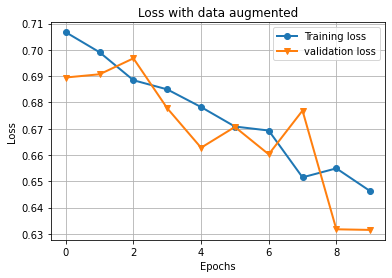

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline


history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs  = range(len(loss_values))

plt.plot(epochs,loss_values,marker='o',lw=2,label='Training loss')
plt.plot(epochs,val_loss_values,marker='v',lw=2,label='validation loss')
plt.title("Loss with data augmented")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

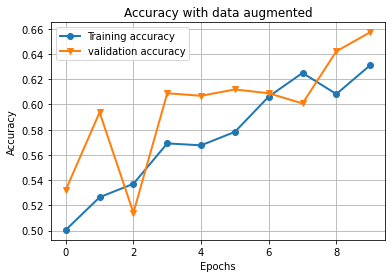

In [79]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epochs  = range(len(acc_values))

plt.plot(epochs,acc_values,marker='o',lw=2,label='Training accuracy')
plt.plot(epochs,val_acc_values,marker='v',lw=2,label='validation accuracy')
plt.title("Accuracy with data augmented")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

# Test some  data augmented with MNIST dataset

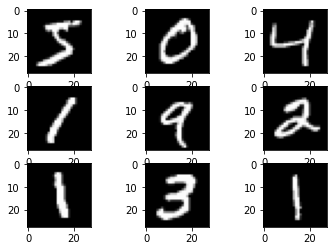

In [2]:
from keras.datasets import mnist
import matplotlib.pyplot as plt

(x_train,y_train),(x_test,y_test) =mnist.load_data()

#show some untouched data
for i in range(9):
    plt.subplot(330+1+i)
    plt.imshow(x_train[i],cmap='gray')

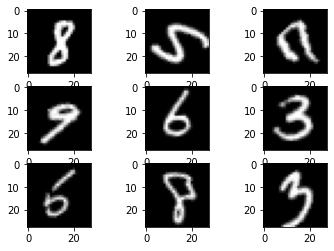

In [5]:
#random rotation
from keras.preprocessing.image import ImageDataGenerator

x_train = x_train.reshape(x_train.shape[0],28,28,1)
x_test = x_test.reshape(x_test.shape[0],28,28,1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

train_datagen = ImageDataGenerator(rotation_range=60)
train_datagen.fit(x_train)

for x_batch,y_batch in train_datagen.flow(x_train,y_train,batch_size=9):
    for i in range(9):
        plt.subplot(330+1+i)
        plt.imshow(x_batch[i].reshape(28,28),cmap='gray')
    break

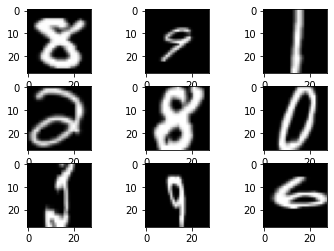

In [6]:
#random shearing and zooming
train_datagen = ImageDataGenerator(shear_range=0.5,zoom_range=0.5)

train_datagen.fit(x_train)

for x_batch,y_batch in train_datagen.flow(x_train,y_train,batch_size=9):
    for i in range(9):
        plt.subplot(330+1+i)
        plt.imshow(x_batch[i].reshape(28,28),cmap='gray')
    break

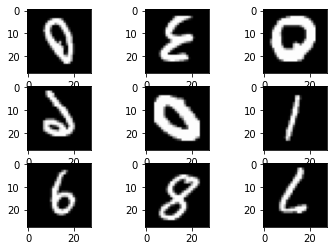

In [7]:
# random horizotal and flip
train_datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True)

train_datagen.fit(x_train)

for x_batch,y_batch in train_datagen.flow(x_train,y_train,batch_size=9):
    for i in range(9):
        plt.subplot(330+1+i)
        plt.imshow(x_batch[i].reshape(28,28),cmap='gray')
    break

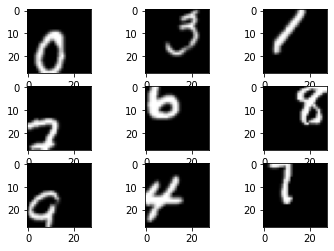

In [9]:
#random shift
train_datagen = ImageDataGenerator(width_shift_range=0.3,height_shift_range=0.3)

train_datagen.fit(x_train)

for x_batch,y_batch in train_datagen.flow(x_train,y_train,batch_size=9):
    for i in range(9):
        plt.subplot(330+1+i)
        plt.imshow(x_batch[i].reshape(28,28),cmap='gray')
    break

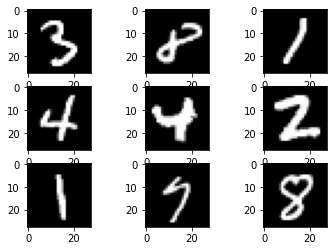

In [10]:
train_datagen = ImageDataGenerator(fill_mode='nearset')

train_datagen.fit(x_train)

for x_batch,y_batch in train_datagen.flow(x_train,y_train,batch_size=9):
    for i in range(9):
        plt.subplot(330+1+i)
        plt.imshow(x_batch[i].reshape(28,28),cmap='gray')
    break